 Test Data Loaded — Shape: (200, 2)
 Model and Scaler Loaded Successfully
Threshold=0.10 | Accuracy=0.995 | F1=0.995
Threshold=0.20 | Accuracy=1.000 | F1=1.000
Threshold=0.30 | Accuracy=1.000 | F1=1.000
Threshold=0.40 | Accuracy=1.000 | F1=1.000
Threshold=0.50 | Accuracy=1.000 | F1=1.000
Threshold=0.60 | Accuracy=1.000 | F1=1.000
Threshold=0.70 | Accuracy=1.000 | F1=1.000
Threshold=0.80 | Accuracy=1.000 | F1=1.000
Threshold=0.90 | Accuracy=1.000 | F1=1.000

 Best threshold found: 0.20 (F1=1.000)

=== Confusion Matrix (Counts) ===
[[100   0]
 [  0 100]]

=== Confusion Matrix (Normalized %) ===
[[100.   0.]
 [  0. 100.]]

 True Positives (TP): 100
 False Positives (FP): 0
 False Negatives (FN): 0
 True Negatives (TN): 100

 Accuracy  : 1.0000
 Precision : 1.0000
 Recall    : 1.0000
 F1-Score  : 1.0000

=== Classification Report ===
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000       100
         1.0     1.0000    1.0000    1.0000      

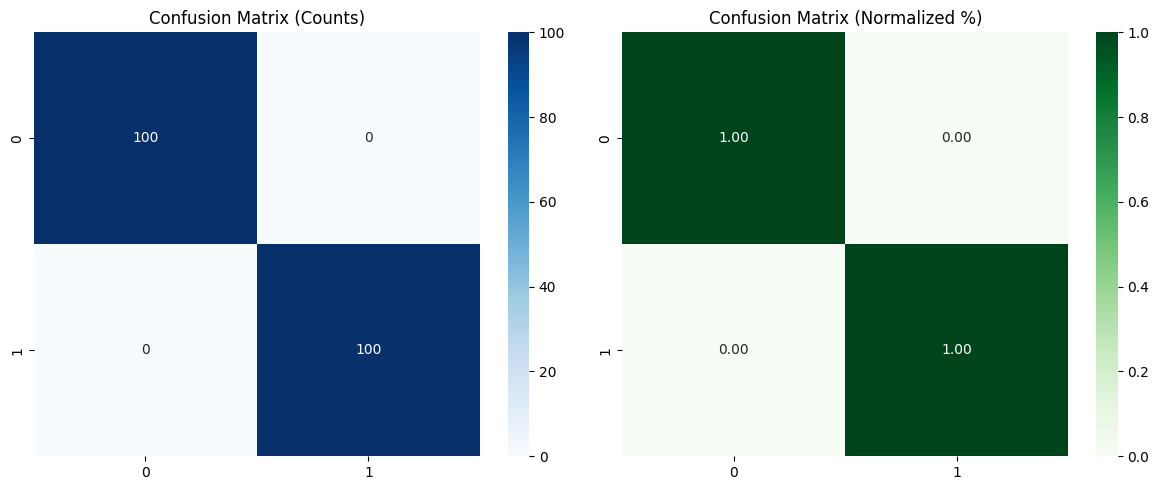

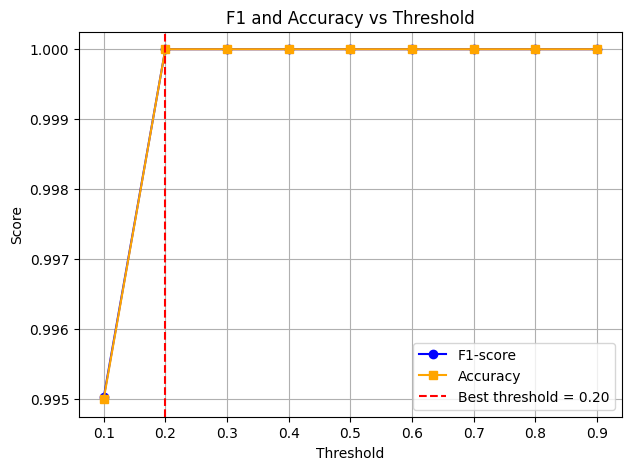

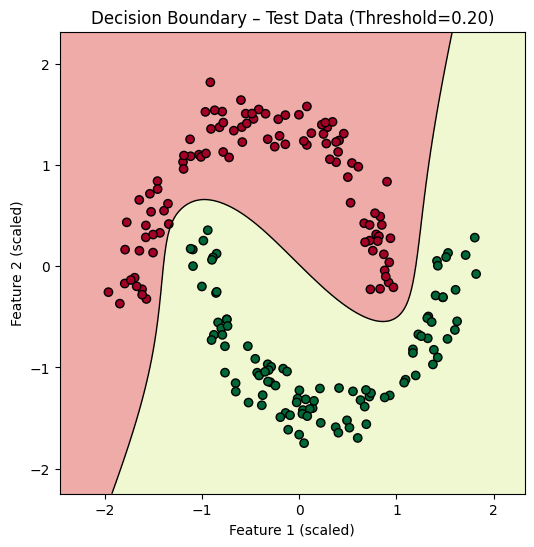

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import joblib, requests



# GitHub raw links (public model files)
model_url = "https://raw.githubusercontent.com/mganesh1610/ANC_HW2_Individual/main/models/double_moon_model.pth"
scaler_url = "https://raw.githubusercontent.com/mganesh1610/ANC_HW2_Individual/main/models/scaler.pkl"
test_url = "https://drive.google.com/uc?id=16KUNDnIjxM_YtH3avKsPfhZbczjnVnqW"

# Download model & scaler from GitHub
open("double_moon_model.pth", "wb").write(requests.get(model_url).content)
open("scaler.pkl", "wb").write(requests.get(scaler_url).content)

# Load test dataset
df_test = pd.read_csv(test_url)
X_test = df_test.iloc[:, 0:2].values
y_test = df_test.iloc[:, 2].values.reshape(-1, 1).astype(np.float32)
y_test_bin = (y_test - y_test.min()) / (y_test.max() - y_test.min())

print(f" Test Data Loaded — Shape: {X_test.shape}")


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 1)
        self.tanh = nn.Tanh()
        for layer in [self.layer1, self.layer2, self.layer3]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        return self.layer3(x)


scaler = joblib.load("scaler.pkl")
X_test_scaled = scaler.transform(X_test)

model = MLP()
state_dict = torch.load("double_moon_model.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

print(" Model and Scaler Loaded Successfully")


X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).numpy().flatten()


thresholds = np.linspace(0.1, 0.9, 9)
best_thresh, best_f1 = 0.5, 0

f1_scores, acc_scores = [], []
for t in thresholds:
    preds_t = (probs > t).astype(int)
    f1 = f1_score(y_test_bin, preds_t)
    acc = accuracy_score(y_test_bin, preds_t)
    f1_scores.append(f1)
    acc_scores.append(acc)
    print(f"Threshold={t:.2f} | Accuracy={acc:.3f} | F1={f1:.3f}")
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"\n Best threshold found: {best_thresh:.2f} (F1={best_f1:.3f})")


preds = (probs > best_thresh).astype(int)


cm = confusion_matrix(y_test_bin, preds)
cm_norm = confusion_matrix(y_test_bin, preds, normalize="true")

# Handle possible multiclass (if numerical noise introduced)
if cm.shape == (3, 3):
    cm = cm[:2, :2]
    cm_norm = cm_norm[:2, :2]

tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

print("\n=== Confusion Matrix (Counts) ===")
print(cm)
print("\n=== Confusion Matrix (Normalized %) ===")
print(np.round(cm_norm * 100, 2))

print(f"\n True Positives (TP): {tp}")
print(f" False Positives (FP): {fp}")
print(f" False Negatives (FN): {fn}")
print(f" True Negatives (TN): {tn}")
print(f"\n Accuracy  : {accuracy:.4f}")
print(f" Precision : {precision:.4f}")
print(f" Recall    : {recall:.4f}")
print(f" F1-Score  : {f1:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test_bin, preds, digits=4))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix (Normalized %)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 5))
plt.plot(thresholds, f1_scores, marker="o", label="F1-score", color="blue")
plt.plot(thresholds, acc_scores, marker="s", label="Accuracy", color="orange")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best threshold = {best_thresh:.2f}")
plt.title("F1 and Accuracy vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


xx, yy = np.meshgrid(
    np.linspace(X_test_scaled[:, 0].min() - 0.5, X_test_scaled[:, 0].max() + 0.5, 300),
    np.linspace(X_test_scaled[:, 1].min() - 0.5, X_test_scaled[:, 1].max() + 0.5, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    zz = torch.sigmoid(model(grid_tensor)).numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, zz, levels=[0, best_thresh, 1], cmap="RdYlGn", alpha=0.4)
plt.contour(xx, yy, zz, levels=[best_thresh], colors="black", linewidths=1.0)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test_bin.flatten(), cmap="RdYlGn", edgecolor="k")
plt.title(f"Decision Boundary – Test Data (Threshold={best_thresh:.2f})")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()
